In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')#TODO change helper.py file so inharmoniicity is from . and also change midi file so sharedtypes is in lib rather than midi folder
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [21]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

In [43]:
print(time_to_next)



[196.61458333333331, 197.91666666666669, 197.91666666666669, 196.61458333333326, 197.91666666666674, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666674, 196.61458333333326, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666788, 196.61458333333212, 197.91666666666788, 197.91666666666606, 197.91666666666606,

In [23]:
# Create cov_dict

cov_dict = {}
sample_length = 500
sample_rate = 44100
M=9
T=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=T, v=v) + sigma_n**2 * np.eye(sample_length)

In [24]:
# Create state transmission matrix, T. Here we are using uniform distribution as all notes are the same length

# For now we will go with a very simple uniform distribution to the current or next state
K = len(score[:130]) # The number of states, K
T = np.full((K, K), -np.inf) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = np.log(1) # Update final row so transition probability is one, to itself



In [25]:
print(T)

[[-0.69314718 -0.69314718        -inf ...        -inf        -inf
         -inf]
 [       -inf -0.69314718 -0.69314718 ...        -inf        -inf
         -inf]
 [       -inf        -inf -0.69314718 ...        -inf        -inf
         -inf]
 ...
 [       -inf        -inf        -inf ... -0.69314718 -0.69314718
         -inf]
 [       -inf        -inf        -inf ...        -inf -0.69314718
  -0.69314718]
 [       -inf        -inf        -inf ...        -inf        -inf
   0.        ]]


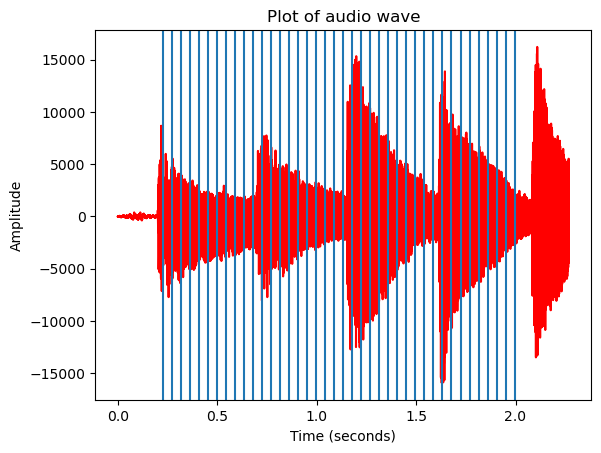

In [26]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 2000

show = 100000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [56]:
def viterbi(y: List[np.ndarray], states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = len(states) # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 12
    chunk = 0
    step = w //3
    counter = [] # Conversion rate is  durations per second (d/s)
    conversion_rate = hop_length/ time_to_next[0] # Make an initial guess based on how many hops are in  midi ttn
    print(conversion_rate)

    d = 1 # d tracks the duration number (ie this incremements each time we perform a self transition)
    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -(helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict))**0.1
    gamma[0,0] = 1 * lml # Initialise probability of first audio sample with state 1

    # Iterate through observations
    for i in range(1, n):
        k0_index = chunk * step

        # Calculate transition probabilities TODO this is way too small relatively
        expected = conversion_rate * time_to_next[max_s] / 1000
        print("Expected is ",expected)
        p = 1 / expected # probability 
        q = 1 - p
        advance_transition = np.log(np.sum([q**i * p for i in range(d)]))
        self_transition = np.log(1 - advance_transition)
        print(self_transition, advance_transition)

        for k in range(k0_index, k0_index + w):

            lml = -(helper.stable_nlml(time_samples, y[i], M=9,sigma_f=1/500000, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)**0.05 ) 
            print("lml, ", lml)
            same_state = lml + gamma[k,i-1] + self_transition
            advance_state = lml + gamma[k-1, i-1] + advance_transition
        

            if same_state >= advance_state:
                gamma[k, i] = same_state
                delta[k, i] = k
            else:
                gamma[k, i] = advance_state
                delta[k, i] = k - 1

        new_s = np.argmax(gamma[:,i])
        if new_s == max_s:
            d +=1
        else:
            counter.append(d)
            conversion_rates = 1000 * np.array(counter)/ np.array(time_to_next[:len(counter)]) # Multiply by 1000 to make seconds
            conversion_rate =  np.mean(conversion_rates) # Conversion is how many durations counts d per second. We take the running mean average
            d = 1
        max_s = new_s
        print(max_s, flush=True)
        path.append(max_s)
        if max_s >= k0_index + w - step:
            chunk += 1
            print('new chunk!: ', chunk)
    
    # Build the optimal path, for comparison to live output
    optimal_path = np.zeros(n, 'B')
    optimal_path[-1] = np.argmax(gamma[:, n-1])

    for i in reversed(range(1, n)):
        optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path,counter


path, optimal, counter = viterbi(audio_data[:40], score[:40], cov_dict=cov_dict )
print(path, optimal)

    

10.172185430463577
Expected is  2.0
0.5265890341390446 -0.6931471805599453
lml,  -2.881880627502403
lml,  -3.56264946359067
lml,  -3.6403135946662464
lml,  -3.67027547703215
lml,  -3.6796314919444906
lml,  -3.6403135946662464
lml,  -3.67027547703215
lml,  -3.6796314919444906
lml,  -2.881880627502403
lml,  -3.56264946359067
lml,  -3.6403135946662464
lml,  -3.67027547703215
0
Expected is  2.0
0.2528437590540542 -0.2876820724517809
lml,  -2.7413681625716046
lml,  -3.533562224606405
lml,  -3.5921329632373618
lml,  -3.607468265063505
lml,  -3.641422730123201
lml,  -3.5921329632373618
lml,  -3.607468265063505
lml,  -3.641422730123201
lml,  -2.7413681625716046
lml,  -3.533562224606405
lml,  -3.5921329632373618
lml,  -3.607468265063505
0
Expected is  2.0
0.12533788588367925 -0.13353139262452263
lml,  -2.8615794414245164
lml,  -3.4771822933972123
lml,  -3.4715335815608204
lml,  -3.5022857985573257
lml,  -3.562354379119666
lml,  -3.4715335815608204
lml,  -3.5022857985573257
lml,  -3.562354379119

In [28]:
print(counter)

[11, 10, 10]


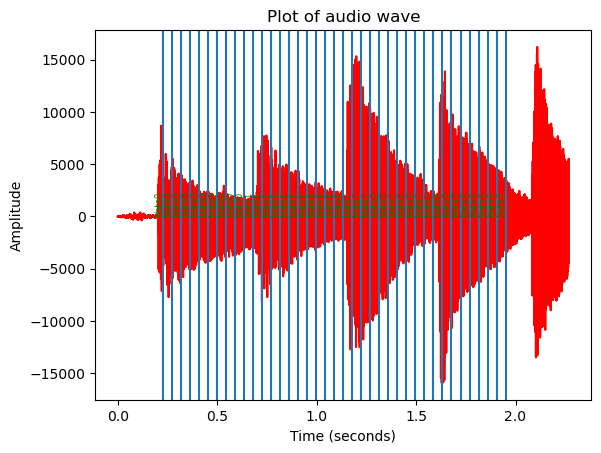

In [58]:
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:39]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{path[_]}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    